In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wrong-direction/README.dataset.txt
/kaggle/input/wrong-direction/README.roboflow.txt
/kaggle/input/wrong-direction/data.yaml
/kaggle/input/wrong-direction/valid/labels/VID_20220906_100833_mp4-46_jpg.rf.f1600caeebadb219bf226c4c7f5aea04.txt
/kaggle/input/wrong-direction/valid/labels/VID_20220913_163807_mp4-292_jpg.rf.da1b2d5a82efea7d39be46816f17777a.txt
/kaggle/input/wrong-direction/valid/labels/VID_20220913_163807_mp4-8_jpg.rf.6e760f6b7581944ea4018cda887be11d.txt
/kaggle/input/wrong-direction/valid/labels/lv_0_20220915144906_mp4-172_jpg.rf.21a1b10971dcab9c0196ebd2a8db6d0a.txt
/kaggle/input/wrong-direction/valid/labels/VID_20220906_100833_mp4-99_jpg.rf.52ec0bd05aff11f23c46df8df8c20fc4.txt
/kaggle/input/wrong-direction/valid/labels/VID_20220913_163807_mp4-161_jpg.rf.1a4bcbdcee6f2dcf684dcdd8c48a9b99.txt
/kaggle/input/wrong-direction/valid/labels/VID_20220913_163807_mp4-25_jpg.rf.1b5cd0cd9f6dc40d87e52626dd8cb91e.txt
/kaggle/input/wrong-direction/valid/labels/VID_20220823_13522

In [2]:
!pip install ultralytics --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
import shutil

# Function to clean and copy dataset
def clean_dataset(SOURCE_IMAGE_DIR, SOURCE_LABEL_DIR, DEST_IMAGE_DIR, DEST_LABEL_DIR):
    os.makedirs(DEST_IMAGE_DIR, exist_ok=True)
    os.makedirs(DEST_LABEL_DIR, exist_ok=True)

    def is_valid_label(label_path):
        if os.stat(label_path).st_size == 0:
            return False
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    return False
                try:
                    values = list(map(float, parts[1:]))
                    if any(v < 0 or v > 1 for v in values):
                        return False
                except:
                    return False
        return True

    valid_count = 0
    skipped = 0
    for img_file in os.listdir(SOURCE_IMAGE_DIR):
        if not img_file.lower().endswith(('.jpg', '.png')):
            continue

        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(SOURCE_LABEL_DIR, label_file)
        img_path = os.path.join(SOURCE_IMAGE_DIR, img_file)

        if os.path.exists(label_path) and is_valid_label(label_path):
            shutil.copy2(img_path, os.path.join(DEST_IMAGE_DIR, img_file))
            shutil.copy2(label_path, os.path.join(DEST_LABEL_DIR, label_file))
            valid_count += 1
        else:
            skipped += 1

    print(f"✅ {DEST_IMAGE_DIR.split('/')[-2].capitalize()} set cleaned.")
    print(f"Valid files copied: {valid_count}")
    print(f"Skipped due to missing/invalid labels: {skipped}\n")

# Clean train
clean_dataset(
    '/kaggle/input/wrong-direction/train/images',
    '/kaggle/input/wrong-direction/train/labels',
    '/kaggle/working/cleaned_dataset/train/images',
    '/kaggle/working/cleaned_dataset/train/labels'
)

# Clean valid
clean_dataset(
    '/kaggle/input/wrong-direction/valid/images',
    '/kaggle/input/wrong-direction/valid/labels',
    '/kaggle/working/cleaned_dataset/valid/images',
    '/kaggle/working/cleaned_dataset/valid/labels'
)

# Clean test
clean_dataset(
    '/kaggle/input/wrong-direction/test/images',
    '/kaggle/input/wrong-direction/test/labels',
    '/kaggle/working/cleaned_dataset/test/images',
    '/kaggle/working/cleaned_dataset/test/labels'
)

✅ Train set cleaned.
Valid files copied: 352
Skipped due to missing/invalid labels: 1

✅ Valid set cleaned.
Valid files copied: 143
Skipped due to missing/invalid labels: 1

✅ Test set cleaned.
Valid files copied: 9
Skipped due to missing/invalid labels: 0



In [4]:
yaml_content = """
train: /kaggle/working/cleaned_dataset/train/images
val: /kaggle/working/cleaned_dataset/valid/images
test: /kaggle/working/cleaned_dataset/test/images

nc: 2
names: ['vehicle', 'wrong_way']
"""

with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(yaml_content.strip())


In [5]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')  
# Train
model.train(
    data="/kaggle/working/data.yaml",  # path to your config
    epochs=100,
    imgsz=640,
    batch=16,
    conf=0.5,
    name="wrong_way_detector_v2",
    cos_lr=True,
    augment=True,
    lr0=0.005,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.5, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, ko

100%|██████████| 755k/755k [00:00<00:00, 28.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3637.9±638.2 MB/s, size: 707.9 KB)


train: Scanning /kaggle/working/cleaned_dataset/train/labels... 352 images, 0 backgrounds, 0 corrupt: 100%|██████████| 352/352 [00:00<00:00, 1498.62it/s]

train: New cache created: /kaggle/working/cleaned_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1463.8±1160.1 MB/s, size: 569.5 KB)


val: Scanning /kaggle/working/cleaned_dataset/valid/labels... 143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<00:00, 1546.21it/s]

val: New cache created: /kaggle/working/cleaned_dataset/valid/labels.cache


Plotting labels to runs/detect/wrong_way_detector_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/wrong_way_detector_v2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.17G      5.149      7.254      4.271         40        640: 100%|██████████| 22/22 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]

                   all        143        207          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.19G      4.154      5.643      3.994         45        640: 100%|██████████| 22/22 [00:07<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

                   all        143        207          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.21G      3.083      4.243      3.241         39        640: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all        143        207          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.22G      2.626       3.46      2.553         34        640: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

                   all        143        207          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.24G      2.427      3.134      2.364         53        640: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.10it/s]

                   all        143        207          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.26G      2.361      2.797      2.188         36        640: 100%|██████████| 22/22 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        143        207          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.28G      2.182      2.516      2.007         27        640: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        143        207      0.607      0.195      0.399      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.29G       2.07       2.32       1.89         50        640: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.14it/s]

                   all        143        207       0.38      0.157      0.267       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.31G      2.039      2.109      1.791         38        640: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]

                   all        143        207      0.492      0.369      0.416      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.33G      1.914      2.011      1.749         45        640: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

                   all        143        207       0.95      0.235      0.598      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.34G      1.902      1.849      1.651         40        640: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]

                   all        143        207      0.883      0.143      0.516      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.36G       1.88      1.812      1.711         39        640: 100%|██████████| 22/22 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]

                   all        143        207       0.99      0.286       0.64      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.38G      1.742       1.61      1.609         41        640: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        143        207      0.929      0.473      0.705       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.39G      1.653      1.515      1.519         38        640: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]

                   all        143        207      0.906      0.496      0.716       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.41G      1.719      1.428      1.516         50        640: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]

                   all        143        207      0.938      0.334       0.64      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.43G      1.715       1.46      1.521         44        640: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]

                   all        143        207      0.877      0.603      0.754      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.45G      1.667      1.433      1.522         56        640: 100%|██████████| 22/22 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        143        207      0.892      0.445      0.677        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.46G      1.643      1.367      1.511         27        640: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]

                   all        143        207      0.976       0.45      0.714      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.48G      1.605      1.318      1.438         37        640: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.93it/s]

                   all        143        207      0.944      0.353      0.653      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.5G      1.554      1.283      1.426         31        640: 100%|██████████| 22/22 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

                   all        143        207      0.873      0.655      0.787       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.52G      1.551      1.168      1.403         31        640: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]

                   all        143        207      0.883      0.689      0.803        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.53G      1.542      1.197       1.41         49        640: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]

                   all        143        207       0.91      0.666      0.813      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.55G      1.489      1.156      1.382         35        640: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]

                   all        143        207      0.931      0.629      0.791      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.57G      1.561      1.155       1.39         44        640: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.31it/s]

                   all        143        207      0.934      0.585      0.767      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.58G      1.521      1.155      1.354         33        640: 100%|██████████| 22/22 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.83it/s]

                   all        143        207      0.927      0.698      0.827      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.6G      1.453      1.073       1.32         41        640: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

                   all        143        207      0.821       0.89      0.898      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.62G      1.476        1.1      1.345         46        640: 100%|██████████| 22/22 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]

                   all        143        207      0.862      0.823      0.869      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.63G      1.451      1.057      1.368         37        640: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.65it/s]

                   all        143        207      0.837      0.689      0.813      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.65G      1.416      1.029      1.303         39        640: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

                   all        143        207      0.927       0.59      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.67G      1.394       1.02      1.288         37        640: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]

                   all        143        207       0.94      0.681      0.828      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.69G      1.396     0.9815      1.303         44        640: 100%|██████████| 22/22 [00:07<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

                   all        143        207      0.894      0.731      0.841      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.7G      1.376      0.965      1.269         38        640: 100%|██████████| 22/22 [00:06<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]

                   all        143        207      0.917      0.734      0.843      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.72G      1.377     0.9887      1.284         39        640: 100%|██████████| 22/22 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]

                   all        143        207      0.875      0.756       0.83      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.74G      1.366     0.9895      1.284         35        640: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

                   all        143        207      0.913      0.724      0.844       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.75G      1.372     0.9643      1.274         40        640: 100%|██████████| 22/22 [00:07<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]

                   all        143        207      0.923      0.633      0.788      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.77G      1.325     0.9301      1.242         34        640: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

                   all        143        207      0.886      0.797      0.869      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.79G      1.341     0.8982       1.25         57        640: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.21it/s]

                   all        143        207      0.947      0.689      0.831      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.8G      1.328     0.9146      1.251         39        640: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        143        207      0.957      0.602      0.788      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.82G      1.353      0.893       1.24         42        640: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all        143        207      0.909      0.731      0.837      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.84G      1.313      0.891      1.226         24        640: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        143        207      0.882      0.787      0.861      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.86G      1.285     0.8867      1.228         38        640: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.82it/s]

                   all        143        207      0.849      0.809      0.868      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.87G       1.27     0.8466      1.203         39        640: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]

                   all        143        207      0.938      0.763      0.865      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.89G      1.273     0.8512      1.213         35        640: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]

                   all        143        207       0.92      0.723      0.839       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.91G      1.287     0.8481      1.225         41        640: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]

                   all        143        207      0.894      0.798      0.872      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.92G      1.256     0.8534      1.203         46        640: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]

                   all        143        207      0.836      0.845      0.862      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.94G       1.28     0.8546      1.254         44        640: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.04it/s]

                   all        143        207      0.901      0.773      0.863      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.96G       1.24     0.8434      1.179         41        640: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]

                   all        143        207      0.867      0.824      0.877      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.97G       1.29     0.8537      1.222         47        640: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

                   all        143        207      0.903      0.816      0.889      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.99G      1.265     0.8163      1.235         31        640: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

                   all        143        207      0.899      0.842      0.893      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.01G       1.24     0.8308      1.224         43        640: 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

                   all        143        207      0.877      0.848      0.895      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.03G      1.245     0.8216      1.183         41        640: 100%|██████████| 22/22 [00:06<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all        143        207      0.884      0.868      0.905      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.04G      1.242     0.8233      1.177         35        640: 100%|██████████| 22/22 [00:06<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.15it/s]

                   all        143        207      0.869       0.81      0.864      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.06G      1.215     0.8002      1.184         43        640: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all        143        207       0.95      0.794      0.886      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.08G       1.22     0.7832      1.176         46        640: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


                   all        143        207      0.885      0.838      0.886       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.1G      1.248     0.8085      1.194         30        640: 100%|██████████| 22/22 [00:05<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all        143        207      0.924      0.743      0.857      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.11G        1.2     0.7791       1.16         51        640: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

                   all        143        207      0.914      0.785      0.865      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.13G      1.184     0.7544      1.159         38        640: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.94it/s]

                   all        143        207      0.918       0.79      0.883      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.15G      1.181     0.7574      1.144         38        640: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.33it/s]

                   all        143        207      0.918      0.808      0.876      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.16G       1.15     0.7019      1.125         41        640: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

                   all        143        207      0.923      0.799      0.876      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.18G      1.161     0.7137      1.156         41        640: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.06it/s]

                   all        143        207      0.936      0.765      0.864        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.2G      1.171     0.7281      1.142         44        640: 100%|██████████| 22/22 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        143        207      0.891      0.848      0.895      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.21G      1.161     0.7386      1.144         32        640: 100%|██████████| 22/22 [00:05<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


                   all        143        207      0.879      0.865      0.904      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.23G       1.14     0.7019      1.118         51        640: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

                   all        143        207      0.924       0.81      0.884      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.25G      1.134     0.7008      1.125         39        640: 100%|██████████| 22/22 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.67it/s]

                   all        143        207      0.968      0.766      0.873      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.27G      1.143     0.7211      1.123         38        640: 100%|██████████| 22/22 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

                   all        143        207      0.958      0.784      0.878      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.28G      1.147     0.7077      1.132         48        640: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.18it/s]

                   all        143        207      0.901      0.793      0.872      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.3G       1.12     0.7107      1.131         28        640: 100%|██████████| 22/22 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]

                   all        143        207      0.904      0.822      0.889       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.32G      1.167     0.7053      1.133         46        640: 100%|██████████| 22/22 [00:06<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]

                   all        143        207      0.892      0.811      0.881      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.33G      1.164     0.7079      1.131         34        640: 100%|██████████| 22/22 [00:06<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

                   all        143        207      0.876      0.903      0.929      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.35G      1.143     0.6888       1.14         39        640: 100%|██████████| 22/22 [00:06<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]

                   all        143        207      0.896       0.86      0.899      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.37G      1.112      0.696      1.124         38        640: 100%|██████████| 22/22 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all        143        207       0.92      0.803      0.881      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.38G      1.105     0.6911      1.111         32        640: 100%|██████████| 22/22 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

                   all        143        207      0.942      0.803      0.889      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.4G      1.085     0.6792      1.109         37        640: 100%|██████████| 22/22 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

                   all        143        207      0.924      0.812      0.891      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.42G      1.101     0.6789       1.12         45        640: 100%|██████████| 22/22 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]

                   all        143        207      0.915      0.812      0.893      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.44G      1.098     0.6559      1.105         51        640: 100%|██████████| 22/22 [00:05<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


                   all        143        207      0.919      0.832      0.903      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.45G       1.06      0.641      1.079         46        640: 100%|██████████| 22/22 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

                   all        143        207      0.915      0.864      0.915      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.47G       1.07     0.6718      1.109         42        640: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]

                   all        143        207      0.917      0.839      0.899       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.49G      1.072     0.6679      1.099         44        640: 100%|██████████| 22/22 [00:06<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


                   all        143        207      0.934      0.844       0.91      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       3.5G      1.112     0.6713      1.097         51        640: 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.19it/s]

                   all        143        207      0.928      0.852      0.913      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.52G      1.075     0.6497      1.087         33        640: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.17it/s]

                   all        143        207      0.905      0.859       0.91      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.54G      1.074     0.6495      1.108         34        640: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.22it/s]

                   all        143        207      0.946      0.804      0.888      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.55G      1.108     0.6599      1.096         41        640: 100%|██████████| 22/22 [00:06<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]

                   all        143        207      0.935      0.862      0.915      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.57G      1.092     0.6527      1.095         41        640: 100%|██████████| 22/22 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

                   all        143        207      0.911      0.862      0.913      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.59G      1.051     0.6265      1.089         35        640: 100%|██████████| 22/22 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]

                   all        143        207      0.951      0.852      0.915      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.61G      1.056     0.6332       1.08         47        640: 100%|██████████| 22/22 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all        143        207      0.946      0.846      0.913      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.62G      1.037     0.6228      1.075         55        640: 100%|██████████| 22/22 [00:05<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all        143        207      0.912      0.876      0.923      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.64G      1.047     0.6471      1.093         26        640: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]

                   all        143        207      0.916      0.886      0.928      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.66G      1.052     0.6372       1.09         48        640: 100%|██████████| 22/22 [00:06<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]

                   all        143        207      0.935       0.86      0.917      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.68G      1.049     0.6333      1.099         48        640: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

                   all        143        207      0.935       0.86      0.916      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.69G      1.047     0.6246       1.08         34        640: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]

                   all        143        207      0.936       0.87      0.921      0.642


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.71G       1.01     0.6495      1.098         26        640: 100%|██████████| 22/22 [00:10<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all        143        207      0.912      0.878      0.921      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.73G     0.9804     0.6035      1.091         21        640: 100%|██████████| 22/22 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


                   all        143        207      0.916      0.858      0.911      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.74G     0.9935     0.6124      1.086         22        640: 100%|██████████| 22/22 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]

                   all        143        207      0.924      0.836      0.902      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.76G     0.9883     0.5816      1.076         22        640: 100%|██████████| 22/22 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

                   all        143        207      0.917      0.838      0.904      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.78G     0.9488     0.5742      1.081         19        640: 100%|██████████| 22/22 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]

                   all        143        207      0.913      0.862      0.914      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.79G     0.9868     0.5797      1.079         27        640: 100%|██████████| 22/22 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

                   all        143        207      0.902      0.862      0.913      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.81G     0.9762      0.573      1.073         18        640: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

                   all        143        207       0.91      0.848      0.913      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.83G      1.007     0.5755      1.072         23        640: 100%|██████████| 22/22 [00:06<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

                   all        143        207      0.908      0.862      0.914       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.85G     0.9664     0.5696      1.076         19        640: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


                   all        143        207      0.915      0.856      0.912      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.86G     0.9723     0.5667      1.084         23        640: 100%|██████████| 22/22 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

                   all        143        207      0.915      0.856      0.913      0.638



100 epochs completed in 0.224 hours.
Optimizer stripped from runs/detect/wrong_way_detector_v2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/wrong_way_detector_v2/weights/best.pt, 6.2MB

Validating runs/detect/wrong_way_detector_v2/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        143        207      0.891      0.924      0.936      0.667
               vehicle         95        121      0.868      0.975      0.975        0.7
             wrong_way         63         86      0.915      0.872      0.898      0.634
Speed: 0.4ms preprocess, 11.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/wrong_way_detector_v2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e0bb3193950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [8]:
import os
for root, dirs, files in os.walk("/kaggle/working"):
    for file in files:
        if file == "best.pt":
            print(os.path.join(root, file))


/kaggle/working/runs/detect/wrong_way_detector_v2/weights/best.pt


In [9]:
from ultralytics import YOLO

model = YOLO('/kaggle/working/runs/detect/wrong_way_detector_v2/weights/best.pt')
metrics = model.val(
    data='/kaggle/working/data.yaml',  # make sure test path is set in this file
    split='test'
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2287.4±704.6 MB/s, size: 415.9 KB)


val: Scanning /kaggle/working/cleaned_dataset/test/labels... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<00:00, 1593.98it/s]

val: New cache created: /kaggle/working/cleaned_dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all          9         11       0.96      0.917      0.975      0.636
               vehicle          4          5       0.95          1      0.995        0.7
             wrong_way          5          6      0.969      0.833      0.955      0.572
Speed: 0.1ms preprocess, 15.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val



image 1/1 /kaggle/working/cleaned_dataset/test/images/lv_0_20220915144906_mp4-59_jpg.rf.a315aeab9375347a14222487a01f4473.jpg: 384x640 1 wrong_way, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


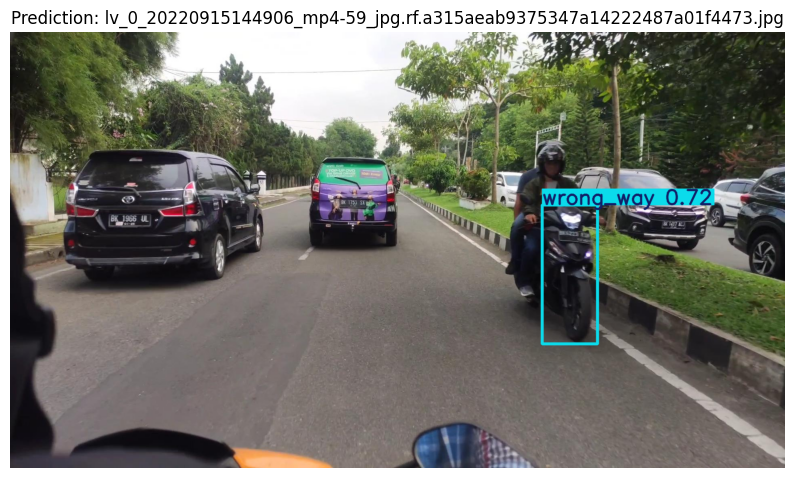

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ✅ Load the trained model
model = YOLO('/kaggle/working/runs/detect/wrong_way_detector_v2/weights/best.pt')

# ✅ Path to a single test image
image_path = '/kaggle/working/cleaned_dataset/test/images/lv_0_20220915144906_mp4-59_jpg.rf.a315aeab9375347a14222487a01f4473.jpg'

# ✅ Run prediction
results = model.predict(image_path, conf=0.5)
annotated_img = results[0].plot()  # Draw bounding boxes

# ✅ Display with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.title(f"Prediction: {os.path.basename(image_path)}")
plt.axis('off')
plt.show()


In [11]:
import shutil

shutil.copy('//kaggle/working/runs/detect/wrong_way_detector_v2/weights/best.pt', '/kaggle/working/wrong_way_model.pt')


'/kaggle/working/wrong_way_model.pt'